### DTW Time Choosing Algorithm

- Asset: HS300(main), SHS50, ZZ500, ZZ1000, SHS50, SZ100, SHS index, SZS index, CY index
- Index: CLOSE, VOLUME **(Two factors model)**
- Frequency: Weekly or Daily
- Time
  - Train date: 20070426-20170821 (20140101-20170821 in CY environment)
  - Test date: 20170822-20221031
- Params
  - Window length
  - Threshold
  - Rank number
- Data structure
  - Input: price DF and reference DF
- Strategy
  - Traditional DTW: Calculate the DTW distance between the current index series and the historical series, choosing the most similar historical series. $ weight = \frac{1}{DTW distance}$. $I$ is series length, $k$ is the threshold for choosing similar series.

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from datetime import date, timedelta, datetime
from scipy.stats import pearsonr
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
minmax = MinMaxScaler()
zscore = StandardScaler()

In [2]:
import psutil
import os

# Get the current process ID of the IPython kernel
pid = os.getpid()
# Get the process associated with the IPython kernel
process = psutil.Process(pid)

def RAM_USAGE():
    # Get the memory usage of the IPython kernel in MB
    ram_usage_MB = process.memory_info().rss / (1024 * 1024)
    ram_usage_GB = process.memory_info().rss / (1024 * 1024 * 1024)

    # Get the total system memory
    total_memory_MB = psutil.virtual_memory().total / (1024 * 1024)
    total_memory_GB = psutil.virtual_memory().total / (1024 * 1024 * 1024)

    # Get RAM usage percentage
    ram_usage_percent = process.memory_percent()

    # Get the CPU usage percentage of the IPython kernel
    cpu_usage = psutil.cpu_percent()

    print(f"RAM Usage MB: {ram_usage_MB:.2f}/" + f"{total_memory_MB:.2f} MB")
    print(f"RAM Usage GB: {ram_usage_GB:.2f}/"+ f"{total_memory_GB:.2f} GB")
    print(f"RAM Usage percentage: {ram_usage_percent:.2f}%")
    print(f"CPU Usage: {cpu_usage}%")

In [3]:
RAM_USAGE()

RAM Usage MB: 196.32/16183.30 MB
RAM Usage GB: 0.19/15.80 GB
RAM Usage percentage: 1.22%
CPU Usage: 72.0%


In [4]:
Online = False

if Online:
    # Suppress the warning
    from cylib.apis.all_api import *
    warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
else:
    warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

path = (os.getcwd() + ("/DTW/" if Online else "/")).replace("\\", '/')

In [5]:
begin_date = "20070426"
# Actual begin date: "20140102" in CY environment
begin_train_date = begin_date
end_train_date = "20170821"
begin_test_date = '20170822'
end_date = '20211031'
end_test_date = end_date
today_date = date.today().strftime('%Y%m%d')

# I = [i for i in range(10, 70, 10)]
# k = [i / 100 for i in range(1, 6, 1)]
# RANK = [rank for rank in range(5, 30, 5)]

### Get Trade Calendar

In [6]:
def Trade_Calendar(Begin_date, End_date, Asset_Type='index'):
    """
    Stay in CY environment: from cylib.apis.all_api import *
    Type: 'stock' or 'convertbond'
    """
    PRICE = get_price(
        ts_code_list=["000300.SH"],
        feature_list=["open"],
        start_date=Begin_date,
        trade_date=End_date,
        target_type=Asset_Type,
    )
    PRICE.reset_index(inplace=True)
    PRICE = PRICE.sort_values(by="trade_date").reset_index(drop=True)
    PRICE_pivot = PRICE.fillna(0)
    PRICE_pivot = PRICE_pivot.pivot(index="trade_date", columns="ts_code", values="open")

    # Attention: len(date_all) >= 60
    date_all = PRICE_pivot.index
    return date_all

if Online:
    date_all = Trade_Calendar(begin_date, end_date)
    date_all_df = pd.DataFrame({'trade_date': date_all})
    date_all_df.to_csv(path + 'date_all_df.csv', index=False)
else: 
    date_all_df = pd.read_csv(path + 'date_all_df.csv',
                            parse_dates=['trade_date'],
                            index_col='trade_date')
    date_all = date_all_df.index

In [7]:
def Position_Changing_Date(Trade_Date, Frequency='Weekly', Times=1):
    """
    Frequency: 'Times' Week(s) or 'Times' Month(s)
    """
    # Trade_Date = Trade_Calendar(Begin_date, End_date)
    # dates = [datetime for date_str in Trade_Date]
    
    # Sort the date list in ascending order
    sorted_dates = sorted(Trade_Date)
    
    Position_dates = []
    if Frequency == 'Monthly':
        current_month = sorted_dates[0].month
        Position_dates.append(sorted_dates[0])
        for date in sorted_dates:
            # Get the month of the current date
            date_month = date.month
            # Check if it's a new month
            if date_month != current_month:
                Position_dates.append(date)
                current_month = date_month
    elif Frequency == 'Weekly':
        current_week = sorted_dates[0].week
        Position_dates.append(sorted_dates[0])
        # dateofweek = date[0].dayofweek
        for date in sorted_dates:
            date_week = date.week
            # Check if it's a new week
            if date_week != current_week:
                Position_dates.append(date)
                current_week = date_week
    else: 
        print("Invalid Frequency input, Please input \'Weekly\' or \'Monthly\'")
        return
    Position_dates = Position_dates[::Times]
    return pd.to_datetime(Position_dates)
def Date_Range_Filter(Begin_date, End_date, Date):
    date_range_filter = (Date >= Begin_date) & (Date <= End_date)
    # filtered = [ts for ts in Date if Begin_date <= ts <= End_date]
    return Date[date_range_filter]

In [8]:
date_position = Position_Changing_Date(date_all, Frequency='Weekly', Times=1)
date_position

DatetimeIndex(['2014-01-02', '2014-01-06', '2014-01-13', '2014-01-20',
               '2014-01-27', '2014-02-07', '2014-02-10', '2014-02-17',
               '2014-02-24', '2014-03-03',
               ...
               '2021-08-23', '2021-08-30', '2021-09-06', '2021-09-13',
               '2021-09-22', '2021-09-27', '2021-10-08', '2021-10-11',
               '2021-10-18', '2021-10-25'],
              dtype='datetime64[ns]', length=403, freq=None)

In [10]:
date_train = Date_Range_Filter(begin_train_date, end_train_date, date_all)
date_train

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2017-08-08', '2017-08-09', '2017-08-10', '2017-08-11',
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-21'],
              dtype='datetime64[ns]', name='trade_date', length=888, freq=None)

In [11]:
date_backtest = Date_Range_Filter(begin_test_date, end_test_date, date_all)
date_backtest

DatetimeIndex(['2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-04',
               ...
               '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
               '2021-10-22', '2021-10-25', '2021-10-26', '2021-10-27',
               '2021-10-28', '2021-10-29'],
              dtype='datetime64[ns]', name='trade_date', length=1017, freq=None)

### Get Price

In [12]:
def Get_Price(Asset_List, Feature_List, Begin_date, End_date):
    """
    Feature list features are lowercase.
    """
    # the Shanghai and Shenzhen 300 index(the HS 300 index) (000300.SH)
    Price_DF = get_price(
        ts_code_list=Asset_List,
        feature_list=Feature_List,
        start_date=Begin_date,
        trade_date=End_date,
        target_type="index",
    )
    Feature_Dict = {}
    for feature in Feature_List:
        Feature_Dict[feature] = feature.upper()
    Price_DF = Price_DF.rename(columns=Feature_Dict)
    Price_DF.reset_index(inplace=True)
    Price_DF = Price_DF.sort_values(by="trade_date").reset_index(drop=True)
    Price_DF.fillna(0, inplace=True)
    return Price_DF

if Online:
    price = Get_Price(
        ["000300.SH"],
        ["open", "close", "volume"],
        begin_date,
        end_date,
    )
    price.to_csv(path + "price.csv", index=False)
else:
    price = pd.read_csv(path + "price.csv", parse_dates=["trade_date"])

In [13]:
price

,trade_date,ts_code,OPEN,CLOSE,VOLUME
0,2014-01-02,000300.SH,2323.43,2321.98,45194300.0
1,2014-01-03,000300.SH,2311.97,2290.78,59782600.0
2,2014-01-06,000300.SH,2286.37,2238.64,66300400.0
3,2014-01-07,000300.SH,2222.31,2238.00,43753100.0
4,2014-01-08,000300.SH,2240.64,2241.91,51348900.0
...,...,...,...,...,...
1900,2021-10-25,000300.SH,4940.90,4979.52,141861000.0
1901,2021-10-26,000300.SH,4983.24,4963.10,140889000.0
1902,2021-10-27,000300.SH,4949.23,4898.16,147112000.0
1903,2021-10-28,000300.SH,4882.59,4864.14,156649000.0


In [14]:
def Find_Missing_Items(Price_DF, Asset_list):
    """
    Finding the missing items in price dataframe.
    Asset_List: The asset list which is the pool of all assets
    """
    PRICE_pivot = Price_DF.pivot(index="trade_date", columns="ts_code", values="OPEN")
    Date_all = PRICE_pivot.index
    
    # Find missing items
    all_combinations = pd.MultiIndex.from_product(
        [Date_all, Asset_list], 
        names=["trade_date", "ts_code"]
    )
    all_combinations_df = pd.DataFrame(index=all_combinations).reset_index()
    
    # Left join
    price_whole = pd.merge(
        all_combinations_df, Price_DF, 
        on=["trade_date", "ts_code"], how="left"
    )
    missing = price_whole[price_whole.isnull().any(axis=1)]
    missing_stock = missing["ts_code"].unique()
    print("The missing items:", missing_stock)

In [15]:
Find_Missing_Items(price, ["000300.SH"])

The missing items: []


In [16]:
# Index = get_price(
#     ts_code_list=[],
#     feature_list=['open'],
#     start_date="20140102",
#     trade_date="20140102",
#     target_type="index",
# )
# Index.reset_index(inplace=True)
# Index = Index.sort_values(by="trade_date").reset_index(drop=True)
# Index_columns = Index['ts_code'].unique()

In [17]:
# Index_columns

### Get Reference

In [18]:
def Get_Reference(Index_List, Feature_List, Begin_date, End_date):
    # Get Reference index
    # 1. the Shanghai and Shenzhen 300 index(the HS 300 index) (000300.SH)
    # 2. the China Securities 500 index (000905.SH)
    # 3. the China Securities 1000 index (000852.SH)
    # SHS50 (000016.SH)
    # SZ100 (399330.SZ)
    # SHS index (000001.SH)
    # SZS index (399001.SZ)
    # CY index (399006.SZ)
    Reference_DF = get_price(
        ts_code_list=Index_List,
        feature_list=Feature_List,
        start_date=Begin_date,
        trade_date=End_date,
        target_type="index",
    )
    Feature_Dict = {}
    for feature in Feature_List:
        Feature_Dict[feature] = feature.upper()
    Reference_DF = Reference_DF.rename(columns=Feature_Dict)
    Reference_DF.reset_index(inplace=True)
    Reference_DF = Reference_DF.sort_values(by="trade_date").reset_index(drop=True)
    Reference_DF.fillna(0, inplace=True)
    return Reference_DF

if Online:
    reference = Get_Reference(
        [
            "000300.SH",
            "000905.SH",
            "000852.SH",
            "000016.SH",
            "399330.SZ",
            "000001.SH",
            "399001.SZ",
            "399006.SZ"
        ],
        ["open", "close", "volume"],
        begin_date,
        end_date
    )
    reference.to_csv(path + "reference.csv", index=False)
else:
    reference = pd.read_csv(path + "reference.csv", parse_dates=["trade_date"])

In [19]:
reference

,trade_date,ts_code,OPEN,CLOSE,VOLUME
0,2014-01-02,000001.SH,2112.13,2109.39,68485500.0
1,2014-01-02,399330.SZ,2694.00,2709.17,13607000.0
2,2014-01-02,399006.SZ,1302.30,1333.00,16376100.0
3,2014-01-02,399001.SZ,8083.77,8114.39,76523700.0
4,2014-01-02,000905.SH,3823.32,3847.88,30800300.0
...,...,...,...,...,...
15235,2021-10-29,000852.SH,7276.51,7385.30,158535000.0
15236,2021-10-29,000905.SH,6955.85,7022.50,170780000.0
15237,2021-10-29,399006.SZ,3275.83,3350.67,114833000.0
15238,2021-10-29,399330.SZ,6718.81,6817.89,48602500.0


### Get Benchmark

In [20]:
def Get_Benchmark(Index_List, Feature_List, Begin_date, End_date):
    # Get Benchmark index
    # 1. the Shanghai and Shenzhen 300 index(the HS 300 index) (000300.SH)
    # 2. the China Securities 500 index (000905.SH)
    # 3. the China Securities 1000 index (000852.SH)
    Benchmark_DF = get_price(
        ts_code_list=Index_List,
        feature_list=Feature_List,
        start_date=Begin_date,
        trade_date=End_date,
        target_type="index",
    )
    Feature_Dict = {}
    for feature in Feature_List:
        Feature_Dict[feature] = feature.upper()
    Benchmark_DF = Benchmark_DF.rename(columns=Feature_Dict)
    Benchmark_DF.reset_index(inplace=True)
    Benchmark_DF = Benchmark_DF.sort_values(by="trade_date").reset_index(drop=True)
    Benchmark_DF.fillna(0, inplace=True)
    return Benchmark_DF

if Online:
    benchmark = Get_Benchmark(
        [
            "000300.SH",
            "000905.SH",
            "000852.SH"
        ],
        ["open", "close", "volume"],
        begin_date,
        end_date
    )
    benchmark.to_csv(path + "benchmark.csv", index=False)
else:
    benchmark = pd.read_csv(path + "benchmark.csv", parse_dates=["trade_date"])

### Get Return

In [21]:
def Get_Return(Price_DF):
    BUY_price = Price_DF.pivot(index="trade_date", columns="ts_code", values="OPEN")
    SELL_price = Price_DF.pivot(index="trade_date", columns="ts_code", values="CLOSE")
    First_Day_return = (SELL_price.iloc[0, :] - BUY_price.iloc[0, :]) / BUY_price.iloc[0, :]
    Price_return_DF = ((SELL_price - SELL_price.shift(1)) / SELL_price.shift(1))
    Price_return_DF.iloc[0, :] = First_Day_return
    return Price_return_DF
price_return = Get_Return(price)
benchmark_return = Get_Return(benchmark)

In [22]:
# def Get_Delay_Return(Price_DF, Delay):
#     BUY_price = Price_DF.pivot(index="trade_date", columns="ts_code", values="OPEN")
#     SELL_price = Price_DF.pivot(index="trade_date", columns="ts_code", values="CLOSE")
#     Price_return_DF = (SELL_price.shift(Delay) - BUY_price) / BUY_price
#     return Price_return_DF
# reference_weekly_return = Get_Delay_Return(reference, -7).dropna()
# reference_weekly_return

In [23]:
# Get benchmark index
# 1. the Shanghai and Shenzhen 300 index(the HS 300 index) (000300.SH)
# 2. the China Securities 500 index (000905.SH)
# 3. the China Securities 1000 index (000852.SH)
# SHS50 (000016.SH)
# SHS index (000001.SH)
# SZS index (399001.SZ)
# CY index (399006.SZ)
# BZ index (899050.BJ)

In [24]:
price.pivot(index='trade_date', columns='ts_code', values='CLOSE')

ts_code,000300.SH
trade_date,
2014-01-02,2321.98
2014-01-03,2290.78
2014-01-06,2238.64
2014-01-07,2238.00
2014-01-08,2241.91
...,...
2021-10-25,4979.52
2021-10-26,4963.10
2021-10-27,4898.16


In [25]:
reference_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')
reference_CLOSE

ts_code,000001.SH,000016.SH,000300.SH,000852.SH,000905.SH,399001.SZ,399006.SZ,399330.SZ
trade_date,,,,,,,,
2014-01-02,2109.39,1561.10,2321.98,4539.50,3847.88,8114.39,1333.00,2709.17
2014-01-03,2083.14,1536.07,2290.78,4531.75,3816.32,8028.33,1352.84,2689.88
2014-01-06,2045.71,1512.93,2238.64,4411.27,3710.90,7818.46,1323.33,2617.72
2014-01-07,2047.32,1510.65,2238.00,4458.56,3733.66,7806.31,1352.28,2618.13
2014-01-08,2044.34,1515.33,2241.91,4504.67,3738.21,7802.14,1405.02,2625.30
...,...,...,...,...,...,...,...,...
2021-10-25,3609.86,3312.30,4979.52,7532.37,7103.99,14596.70,3338.62,6884.55
2021-10-26,3597.64,3290.04,4963.10,7508.69,7102.43,14552.80,3327.54,6852.23
2021-10-27,3562.31,3247.10,4898.16,7433.55,7048.60,14393.50,3308.96,6773.87


In [26]:
reference_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')
reference_VOLUME

ts_code,000001.SH,000016.SH,000300.SH,000852.SH,000905.SH,399001.SZ,399006.SZ,399330.SZ
trade_date,,,,,,,,
2014-01-02,68485500.0,15725500.0,45194300.0,46888000.0,30800300.0,76523700.0,16376100.0,13607000.0
2014-01-03,84497200.0,21899200.0,59782600.0,54297700.0,34817600.0,88760600.0,19116700.0,16294300.0
2014-01-06,89587600.0,24918200.0,66300400.0,55573200.0,34511900.0,90287900.0,17027600.0,17664300.0
2014-01-07,63402900.0,15474100.0,43753100.0,44584900.0,27208600.0,70831000.0,14884400.0,11907900.0
2014-01-08,71647400.0,17721900.0,51348900.0,53139100.0,31943400.0,86217500.0,22492900.0,15145400.0
...,...,...,...,...,...,...,...,...
2021-10-25,321197000.0,28346000.0,141861000.0,150472000.0,159005000.0,362803000.0,104410000.0,39811800.0
2021-10-26,337278000.0,25983500.0,140889000.0,161427000.0,175032000.0,386830000.0,115421000.0,39989600.0
2021-10-27,350621000.0,28044900.0,147112000.0,162086000.0,179021000.0,398325000.0,116327000.0,44542400.0


In [27]:
# HS_300_CLOSE = price.pivot(index='trade_date', columns='ts_code', values='CLOSE')['000300.SH']
# ZZ_500_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')['000905.SH']
# ZZ_1000_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')['000852.SH']
# SHS_50_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')['000016.SH']
# SZ_100_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')["399330.SZ"]
# SHS_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')['000001.SH']
# SZS_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')['399001.SZ']
# CY_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')['399006.SZ']

# HS_300_VOLUME = price.pivot(index='trade_date', columns='ts_code', values='VOLUME')['000300.SH']
# ZZ_500_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')['000905.SH']
# ZZ_1000_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')['000852.SH']
# SHS_50_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')['000016.SH']
# SZ_100_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')["399330.SZ"]
# SHS_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')['000001.SH']
# SZS_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')['399001.SZ']
# CY_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')['399006.SZ']

HS_300_CLOSE = price.pivot(index='trade_date', columns='ts_code', values='CLOSE')
ZZ_500_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')
ZZ_1000_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')
SHS_50_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')
SZ_100_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')
SHS_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')
SZS_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')
CY_CLOSE = reference.pivot(index='trade_date', columns='ts_code', values='CLOSE')

HS_300_VOLUME = price.pivot(index='trade_date', columns='ts_code', values='VOLUME')
ZZ_500_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')
ZZ_1000_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')
SHS_50_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')
SZ_100_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')
SHS_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')
SZS_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')
CY_VOLUME = reference.pivot(index='trade_date', columns='ts_code', values='VOLUME')

In [28]:
HS_300_Return = pd.DataFrame(benchmark_return["000300.SH"])["000300.SH"]
ZZ_500_Return = pd.DataFrame(benchmark_return["000905.SH"])["000905.SH"]
ZZ_1000_Return = pd.DataFrame(benchmark_return["000852.SH"])["000852.SH"]

In [29]:
benchmark_return

ts_code,000300.SH,000852.SH,000905.SH
trade_date,,,
2014-01-02,-0.000624,0.013788,0.006424
2014-01-03,-0.013437,-0.001707,-0.008202
2014-01-06,-0.022761,-0.026586,-0.027623
2014-01-07,-0.000286,0.010720,0.006133
2014-01-08,0.001747,0.010342,0.001219
...,...,...,...
2021-10-25,0.003990,0.012622,0.011090
2021-10-26,-0.003298,-0.003144,-0.000220
2021-10-27,-0.013085,-0.010007,-0.007579


In [30]:
RAM_USAGE()

RAM Usage MB: 203.53/16183.30 MB
RAM Usage GB: 0.20/15.80 GB
RAM Usage percentage: 1.26%
CPU Usage: 93.7%


In [31]:
class Correlation_Strategy:
    def __init__(
        self,
        I: float,
        Window_length: int,
        Future_Day: int,
        Rank_Num: int,
        Price_DF: pd.DataFrame,
        Reference_DF: pd.DataFrame,
        Target_asset: list,
        Choise_Type: str = "Rank",
        Weight_Type: str = "None",                                                                                                                                                                                                        
        Scaler=MinMaxScaler(),
        Scaler_bool: bool = False,
    ):
        """
        I: Thershold
        Window_length: Number of days for compare (k in Research report)
        Future_Day: The future days we calculate the ROI
        Rank_Num: The number of top-ranked assets in the asset pool
        Price_DF: Price DataFrame, with date type index and asset code column
        Reference_DF: The reference asset price DataFrame, for compare usage
        Target_asset: The target asset list for trading
        Choise_Type: 'Rank' or 'Threshold'
        Weight_Type: The weight type for DTW distance calculation
        Scaler: The scaler for data preprocessing
        Scaler_bool: Whether use scaler or not
        """
        self.I = I
        self.window_length = Window_length
        self.future_day = Future_Day
        self.rank_num = Rank_Num
        self.price = Price_DF
        self.reference = Reference_DF
        self.target_asset = Target_asset
        self.choise_type = Choise_Type
        self.weight_type = Weight_Type
        self.scaler = Scaler
        self.scaler_bool = Scaler_bool
    def Data_Preprocessing(self):
        pass
    def DTW(self):
        pass
    def Correlation_Coefficient(self):
        pass

In [32]:
cache = {} # Store initialization matrix

def Matrix2CA(matrix):
    """
    Matrix to coordinate axis for convenient visualization
    """
    return matrix.T[::-1]
def SC_Constraint(S1_len, S2_len, R, X, Y):
    """
    Sakoe-Chiba Constraint
    S1_len: Series 1 length
    S2_len: Series 2 length
    R: Window limiting parameter
    return: bool
    (If the point is in Constraint, return True)
    """
    """
    S1L = S1_len (or S1_len - 1)
    S2L = S2_len
    Diagonal: y = (S2L / S1L) * x
    Left constraint: y = (S2L / S1L) * (x + R)
    Right constraint: y = (S2L / S1L) * (x - R)
    """
    S1L = S1_len - 1
    S2L = S2_len - 1
    LEFT = Y <= (S2L / S1L) * (X + R)
    RIGHT = Y >= (S2L / S1L) * (X - R)
    return LEFT and RIGHT
def IP_Constraint(S1_len, S2_len, K, X, Y):
    """
    Itakura Parallelogram Constraint
    S1_len: Series 1 length
    S2_len: Series 2 length
    K: [K1, K2]
    K1: The slope of upper and down lines
    K2: The slope of left and right lines
    """
    """
    S1L = S1_len (or S1_len - 1)
    S2L = S2_len
    Diagonal: y = (S2L / S1L) * x
    Upper constraint: y = K1 * (x - S1L) + S2L
    Down constraint: y = K1 * x
    Left constraint: y = K2 * (x - S1L) + S2L
    rigth constraint: y = K2 * x
    """
    K1, K2 = K
    S1L = S1_len - 1
    S2L = S2_len - 1
    UPPER = Y <= K1 * (X - S1L) + S2L
    DOWN = Y >= K1 * X
    LEFT = Y <= K2 * X
    RIGHT = Y >= K2 * (X - S1L) + S2L
    return UPPER and DOWN and LEFT and RIGHT
def SC_Cons_Matrix(S1_len, S2_len, R):
    key = ('SC', S1_len, S2_len, R)
    if key in cache:
        return cache[key]
    # Assign to np.inf for all values which are outside of constraint
    matrix = np.zeros((S1_len, S2_len))
    for i in range(S1_len):
        for j in range(S2_len):
            if SC_Constraint(S1_len, S2_len, R, i, j): pass
            else: matrix[i, j] = np.inf
    cache[key] = matrix
    return matrix
def IP_Cons_Matrix(S1_len, S2_len, K):
    K1, K2 = K
    key = ('IP', S1_len, S2_len, K1, K2)
    if key in cache:
        return cache[key]
    # Assign to np.inf for all values which are outside of constraint
    matrix = np.zeros((S1_len, S1_len))
    for i in range(S1_len):
        for j in range(S2_len):
            if IP_Constraint(S1_len, S2_len, K, i, j): pass
            else: matrix[i, j] = np.inf
    cache[key] = matrix
    return matrix
def Draw_Heatmap(Matrix):
    plt.figure()
    IM = plt.imshow(Matrix.T, origin='lower', cmap='gray')
    plt.colorbar(IM)  # Use im as the mappable for colorbar

def Weight_Fun(S1, S2, Path, k: int, Type='None'):
    """
    Type: 'a' or 'b' or 'c' or 'd', or 'None'
    Note that when the type is None, the weight is 1
    Path: Path list like Phi_k = [(1, 2), (2, 3), (3, 3)]
    k: The position of the path, begin with 0
    """
    def Phi_x(Position):
        if Position < 0: return 0
        return Path[Position][0]
    def Phi_y(Position):
        if Position < 0: return 0
        return Path[Position][0]
    def X(Position):
        if Position < 0: return 0
        return S1[Position]
    def Y(Position):
        if Position < 0: return 0
        return S2[Position]
    if Type == 'a':
        return min(Phi_x(k) - Phi_x(k - 1), Phi_y(k) - Phi_y(k - 1))
    elif Type == 'b':
        return max(Phi_x(k) - Phi_x(k - 1), Phi_y(k) - Phi_y(k - 1))
    elif Type == 'c':
        return Phi_x(k) - Phi_x(k - 1)
    elif Type == 'd':
        return Phi_x(k) - Phi_x(k - 1) + Phi_y(k) - Phi_y(k - 1)
    elif Type == 'None': return 1
    else: 
        print("Invalid type. Type in {'a', 'b', 'c', 'd', 'None'\}")
def DTW_Distance(S1, S2, Path, Type):
    # path_values = [Matrix[path[0], path[1]] for path in Path]
    distance_values = []
    Weight_values = []
    index = 0
    for ppath in Path:
        Weight_value = Weight_Fun(S1, S2, Path, index, Type)
        Value = Distance_Fun(S1[ppath[0]], S2[ppath[1]]) * Weight_value
        distance_values.append(Value)
        Weight_values.append(Weight_value)
        index += 1
    return np.sum(distance_values) / np.sum(Weight_values)

def Euclidean_Distance(a, b):
    return np.abs(a - b)
def Squared_euclidean(a, b):
    return (a - b) ** 2
def Distance_Fun(a, b):
    return Squared_euclidean(a, b)

def dtw_cost_matrix_both(series1, series2, R, K, Cons_Type='None'):
    """
    R: window limiting parameter
    Compute the DTW cost matrix between two series. 
    Cons_Type: Constraint type, including {'None', 'SC', 'IP'}
    """
    n = len(series1)
    m = len(series2)
    Normal_cost = np.zeros((n, m))
    Cons_cost = np.zeros((n, m))

    def Initialize_values(matrix):
        # Initialize the first row and first column of the cost matrix
        matrix[0, 0] = Distance_Fun(series1[0], series2[0])
        for i in range(1, n):
            if matrix[i, 0] != np.inf: # If it is np.inf, stop calculating
                matrix[i, 0] = matrix[i-1, 0] + Distance_Fun(series1[i], series2[0])
        for j in range(1, m):
            if matrix[0, j] != np.inf:
                matrix[0, j] = matrix[0, j-1] + Distance_Fun(series1[0], series2[j])
        return matrix

    if Cons_Type == 'None': 
        Cons_cost = Normal_cost
    elif Cons_Type == 'SC':
        Cons_cost = SC_Cons_Matrix(n, m, R)
    elif Cons_Type == 'IP':
        Cons_cost = IP_Cons_Matrix(n, m, K)
    else: print("Invalid input, please input {'None', 'SC', 'IP'}")

    Normal_cost = Initialize_values(Normal_cost)
    Cons_cost = Initialize_values(Cons_cost)

    # Fill the rest of the cost matrix
    for i in range(1, n):
        for j in range(1, m):
            min_cost_cons = min(Cons_cost[i-1, j], Cons_cost[i, j-1], Cons_cost[i-1, j-1])
            min_cost_normal = min(Normal_cost[i-1, j], Normal_cost[i, j-1], Normal_cost[i-1, j-1])
            if Cons_cost[i, j] != np.inf: # If it is np.inf, stop calculating
                Cons_cost[i, j] = Distance_Fun(series1[i], series2[j]) + min_cost_cons
            Normal_cost[i, j] = Distance_Fun(series1[i], series2[j]) + min_cost_normal

    # format_func = np.vectorize(lambda x: "{:.1f}".format(x))
    # print('Constraint cost:')
    # print(format_func(Cons_cost))
    # print('Normal cost:')
    # print(format_func(Normal_cost))
    # print("*" * 30)
    
    return Cons_cost, Normal_cost

def dtw_cost_matrix(series1, series2, R, K, Cons_Type='None'):
    """
    R: window limiting parameter
    Compute the DTW cost matrix between two series. 
    Cons_Type: Constraint type, including {'None', 'SC', 'IP'}
    """
    n = len(series1)
    m = len(series2)
    Cons_cost = np.zeros((n, m))

    def Initialize_values(matrix):
        # Initialize the first row and first column of the cost matrix
        matrix[0, 0] = Distance_Fun(series1[0], series2[0])
        for i in range(1, n):
            if matrix[i, 0] != np.inf: # If it is np.inf, stop calculating
                matrix[i, 0] = matrix[i-1, 0] + Distance_Fun(series1[i], series2[0])
        for j in range(1, m):
            if matrix[0, j] != np.inf:
                matrix[0, j] = matrix[0, j-1] + Distance_Fun(series1[0], series2[j])
        return matrix

    if Cons_Type == 'None': pass
    elif Cons_Type == 'SC':
        Cons_cost = SC_Cons_Matrix(n, m, R)
    elif Cons_Type == 'IP':
        Cons_cost = IP_Cons_Matrix(n, m, K)
    else: print("Invalid input, please input {'None', 'SC', 'IP'}")

    Cons_cost = Initialize_values(Cons_cost)

    # Fill the rest of the cost matrix
    for i in range(1, n):
        for j in range(1, m):
            if Cons_cost[i, j] != np.inf: # If it is np.inf, stop calculating
                min_cost_cons = min(Cons_cost[i-1, j], Cons_cost[i, j-1], Cons_cost[i-1, j-1])
                Cons_cost[i, j] = Distance_Fun(series1[i], series2[j]) + min_cost_cons

    # format_func = np.vectorize(lambda x: "{:.1f}".format(x))
    # print('Constraint cost:')
    # print(format_func(Cons_cost))
    # print('Normal cost:')
    # print(format_func(Normal_cost))
    # print("*" * 30)
    
    return Cons_cost, None

def dtw_path(cost_matrix):
    """ Trace back the optimal DTW path from the cost matrix. """
    n, m = cost_matrix.shape
    i, j = n - 1, m - 1
    ppath = [(i, j)]
    
    while i > 0 or j > 0:
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            min_idx = np.argmin([cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1, j-1]])
            if min_idx == 0:
                i -= 1
            elif min_idx == 1:
                j -= 1
            else:
                i -= 1
                j -= 1
        ppath.append((i, j))
    ppath = [t for t in reversed(ppath)] # Reverse it
    # print("ppath:")
    # print(ppath)
    # print("*" * 30)
    
    # ppath.reverse()
    return np.array(ppath)
def Plot_Series_And_Matrix(series1, series2,
                           R=5, K=[0.5, 2], 
                           Cons_Type='None', 
                           Weight_Type='None',
                           Scaler=MinMaxScaler(), 
                           Scaler_bool=False):
    """
    R: window limiting parameter
    K: [K1, K2]
    """
    if Scaler_bool:
        S1 = Scaler.fit_transform(series1.reshape(-1, 1)).reshape(-1)
        S2 = Scaler.fit_transform(series2.reshape(-1, 1)).reshape(-1)
    else:
        S1 = series1
        S2 = series2
    cons_cost, normal_cost = dtw_cost_matrix(S1, S2, R, K, Cons_Type)
    n, m = cons_cost.shape
    path = dtw_path(cons_cost)
    print(f'DTW Distance 1 = cost(n, m) = {cons_cost[n-1, m-1]}')
    print(f'DTW Distance 1 = cost(n, m) / Len(path) = {cons_cost[n-1, m-1] / len(path)}')
    print("*" * 30)
    print(f"DTW distance 2 = {DTW_Distance(S1, S2, path, Weight_Type)}")

    # Plotting both the line charts and the cost matrix in subplots
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))

    # Plotting series 1 and series 2
    ax1.plot(S1, label='Series 1', marker='o')
    ax1.plot(S2, label='Series 2', marker='o')
    ax1.set_title('Time Series')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend(bbox_to_anchor=(1, 0.5), loc="center left")

    # Check for 'inf' values in the matrix
    inf_mask = np.isinf(cons_cost)
    # Replace 'inf' values with 0 using boolean indexing
    cons_cost[inf_mask] = 0
    
    # Plotting the cost matrix
    im = ax2.imshow(cons_cost.T, origin='lower', cmap='gray', interpolation='nearest')
    ax2.set_title('DTW Cost Matrix')
    ax2.set_xlabel('Series 1')
    ax2.set_ylabel('Series 2')
    plt.colorbar(im, ax=ax2)  # Use im as the mappable for colorbar

    # Overlaying the optimal path
    ax2.plot(path[:, 0], path[:, 1], color='red')

    plt.tight_layout()
    plt.show()

def Calculate_DTW(series1, series2, 
                  R=5, K=[0.5, 2], 
                  Cons_Type='None', 
                  Weight_Type='None', 
                  Scaler=MinMaxScaler(), 
                  Scaler_bool=False):
    """
    R: window limiting parameter
    K: [K1, K2]
    """
    if Scaler_bool:
        S1 = Scaler.fit_transform(series1.reshape(-1, 1)).reshape(-1)
        S2 = Scaler.fit_transform(series2.reshape(-1, 1)).reshape(-1)
    else:
        S1 = series1
        S2 = series2
    cons_cost, normal_cost = dtw_cost_matrix(S1, S2, R, K, Cons_Type)
    ppath = dtw_path(cons_cost)
    # print(path_reversed)
    Distance = DTW_Distance(S1, S2, ppath, Weight_Type)
    return Distance

def Calculate_CORR(series1, series2, Scaler=MinMaxScaler(), Scaler_bool=False):
    if Scaler_bool:
        S1 = Scaler.fit_transform(series1.reshape(-1, 1)).reshape(-1)
        S2 = Scaler.fit_transform(series2.reshape(-1, 1)).reshape(-1)
    else:
        S1 = series1.reshape(-1)
        S2 = series2.reshape(-1)
    return pearsonr(S1, S2).correlation

# Example series
# series1 = np.array([9, 6, 7, 3, 2, 1])
# series2 = np.array([1, 4, 2, 3, 7])
# Plot_Series_And_Matrix(series1, series2, Scaler_bool=False)

In [33]:
# pearsonr(HS_300_CLOSE[0:30].values.reshape(-1), HS_300_CLOSE[30:60].values.reshape(-1)).correlation
Calculate_CORR(HS_300_CLOSE[0:30].values.reshape(-1), HS_300_CLOSE[30:60].values.reshape(-1), Scaler=zscore, Scaler_bool=False)

0.4757984754183722

In [34]:
# Function to calculate correlation between two series
# def calculate_correlation(s1, s2):
#     return s1.corr(s2)

# a = pd.Series(HS_300_CLOSE[0:30].values)
# b = pd.Series(HS_300_CLOSE[100:130].values)
# a.corr(b)

In [35]:
def Rank_All_DF_Values(DF: pd.DataFrame, Ascending=False):
    """
    method : {'average', 'min', 'max', 'first', 'dense'}, default 'average'
    How to rank the group of records that have the same value (i.e. ties) :

    average: average rank of the group
    min: lowest rank in the group
    max: highest rank in the group
    first: ranks assigned in order they appear in the array
    dense: like 'min', but rank always increases by 1 between groups.
    """
    # Flatten the dataframe
    flat_values = DF.values.flatten()

    # Rank all values in the flattened array
    ranked_values = pd.Series(flat_values).rank(ascending=Ascending)

    # Replace the original values with the ranked values in the dataframe
    df_ranked = pd.DataFrame(ranked_values.values.reshape(DF.shape), 
                             index=DF.index, 
                             columns=DF.columns)
    return df_ranked

def Calculate_dtw(Price_Series, 
                  Reference_DF, 
                  Reference_Return, 
                  Window_length, 
                  Profit_length, 
                  Threshold,
                  Rank, R=5, 
                  K=[0.5, 2], 
                  Cons_Type='None', 
                  Filter_Type='Threshold',
                  Weight_Type='None',
                  Scaler=zscore, 
                  Scaler_bool=False):
    """
    R: window limiting parameter
    K: [K1, K2], slope of constraints
    Filter_Type: {"Rank", 'Threshold'}
    Cons_Type: {"SC", "IP", "None}
    """
    Price_Series_Values = Price_Series.values.reshape(-1)
    # print(Price_Series_Values)
    Corr_DF = Reference_DF.rolling(window=Window_length).apply(
        lambda x: Calculate_DTW(Price_Series_Values, 
                                x.values, R, K,
                                Cons_Type,
                                Weight_Type,
                                Scaler=Scaler,
                                Scaler_bool=Scaler_bool)
    ).dropna().iloc[:-Profit_length] # Dropna() to remove the first (Window_length-1) rows
    # print((Corr_DF == 0).any().any())
    # print(Corr_DF)
    Ref_ROI = Reference_Return.iloc[Window_length-1:]
    """
    Remove 0 value. 
    DTW cannot be 0 unless the two sequences are exactly the same.
    """
    Corr_DF = Corr_DF.replace(0, np.inf) 
    # print(Ref_ROI)
    if Filter_Type == 'Threshold':
        # Filter_DF = Corr_DF.applymap(lambda x: 1 if 0 < x < Threshold else 0)
        Filter_DF = (0 < Corr_DF) & (Corr_DF < Threshold)
    elif Filter_Type == 'Rank':
        Rank_DF = Rank_All_DF_Values(Corr_DF, Ascending=True)
        # Filter_DF = Rank_DF.applymap(lambda x: 1 if x < Rank else 0)
        Filter_DF = Rank_DF < Rank
    else: 
        print("Invalid input, please input {'Rank', 'Threshold'}") 
        return
    # print(Filter_DF)
    Weight_DF = 1 / Corr_DF
    # print(Weight_DF)
    Result_DF = (Filter_DF * Weight_DF) * (Filter_DF * Ref_ROI)
    Result = Result_DF.values.sum()
    return Result
def Calculate_corr(Price_Series, 
                  Reference_DF,
                  Reference_Return, 
                  Window_length, 
                  Profit_length, 
                  Threshold, 
                  Scaler=zscore, 
                  Scaler_bool=False):
    Corr_DF = Reference_DF.rolling(window=Window_length).apply(
        lambda x: Calculate_CORR(Price_Series.values.reshape(-1), 
                                x.values, 
                                Scaler=Scaler,
                                Scaler_bool=Scaler_bool)
    ).dropna().iloc[:-Profit_length] # Dropna() to remove the first (Window_length-1) rows
    Ref_ROI = Reference_Return.iloc[Window_length-1:]
    Filter_DF = Corr_DF.applymap(lambda x: 1 if x > Threshold else 0)
    Weight_DF = 1 / Corr_DF
    Result_DF = (Filter_DF * Weight_DF) * (Filter_DF * Ref_ROI)
    Result = Result_DF.values.sum()
    return Result

In [36]:
def DTW_DF(
    Price_Series,
    Reference_DF,
    Window_length,
    R=5, K=[0.5, 2],
    Cons_Type='None',
    Scaler=zscore,
    Scaler_bool=False,
):
    Price_Series_list = Price_Series.values.reshape(-1)
    Corr_DF = Reference_DF.rolling(window=Window_length).apply(
        lambda x: Calculate_DTW(Price_Series_list, 
                                x.values, R, K,
                                Cons_Type,
                                Scaler=Scaler,
                                Scaler_bool=Scaler_bool)
    ).dropna()
    return Corr_DF
# DTW_HS300CLO_RefCLO = DTW_DF(HS_300_CLOSE[-30:], reference_CLOSE, 
#                              30, R=5, K=[0.5, 2], Cons_Type="None",
#                              Scaler=zscore, Scaler_bool=True)
# DTW_HS300CLO_RefCLO

- DTW_HS300CLO_RefCLO_minmax
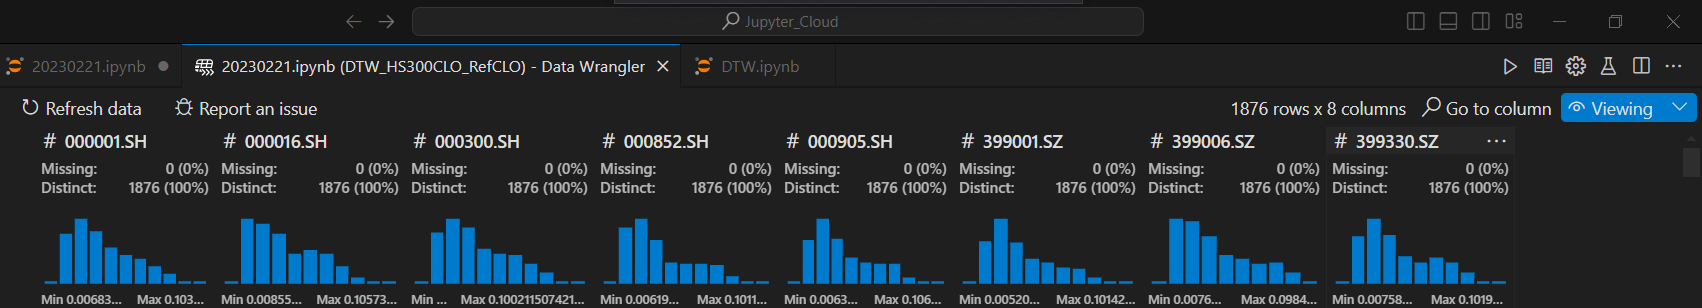

- DTW_HS300CLO_RefCLO_zscore
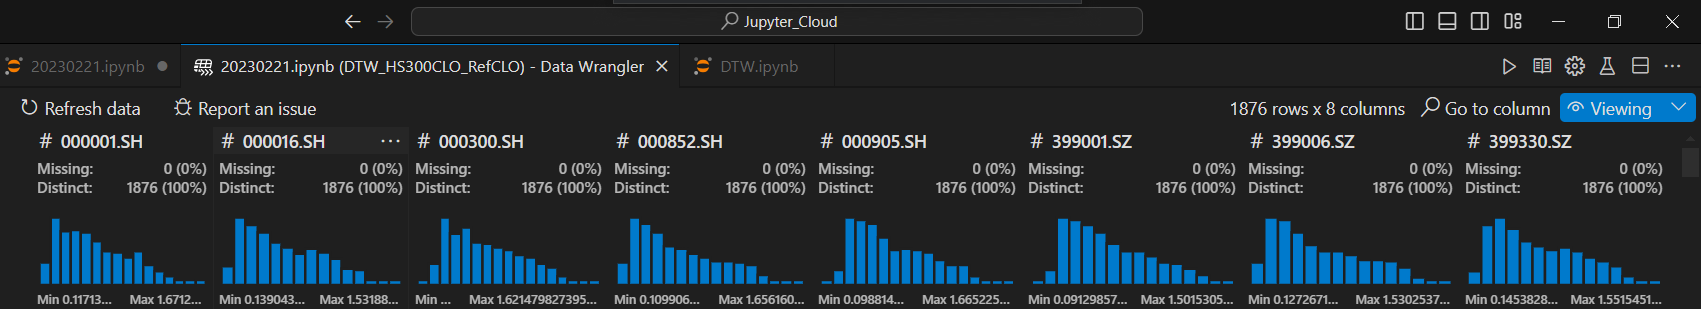

In [37]:
def Get_Delay_Return(Price_DF, Delay):
    BUY_price = Price_DF.pivot(index="trade_date", columns="ts_code", values="OPEN")
    SELL_price = Price_DF.pivot(index="trade_date", columns="ts_code", values="CLOSE")
    Price_return_DF = (SELL_price.shift(Delay) - BUY_price) / BUY_price
    return Price_return_DF
reference_weekly_return = Get_Delay_Return(reference, -7).dropna()
reference_weekly_return

ts_code,000001.SH,000016.SH,000300.SH,000852.SH,000905.SH,399001.SZ,399006.SZ,399330.SZ
trade_date,,,,,,,,
2014-01-02,-0.048562,-0.048049,-0.055844,-0.029267,-0.055266,-0.063239,0.046449,-0.058630
2014-01-03,-0.035545,-0.034864,-0.042873,-0.018306,-0.041052,-0.050970,0.051465,-0.047325
2014-01-06,-0.026618,-0.029971,-0.033866,-0.006179,-0.025860,-0.042999,0.048145,-0.040355
2014-01-07,-0.005172,-0.005257,-0.004711,0.021364,0.003895,-0.012078,0.060603,-0.009768
2014-01-08,-0.020667,-0.024086,-0.027738,-0.004666,-0.017020,-0.034850,0.023619,-0.033189
...,...,...,...,...,...,...,...,...
2021-10-14,0.015400,0.006784,0.009173,0.035162,0.019129,0.017149,0.037851,0.018033
2021-10-15,0.012852,0.009658,0.013589,0.025556,0.015196,0.018091,0.040217,0.021038
2021-10-18,-0.002447,-0.012835,-0.004947,0.012115,0.003054,0.000021,0.006669,-0.000892


In [38]:
def Calculate_Factor(
    Date_All: list,
    Date_Position: list,
    Price_DF: pd.DataFrame,
    Reference_DF: pd.DataFrame,
    Reference_Return: pd.DataFrame,
    Window_Len: int,
    Profit_Len: int,
    Threshold: float,
    Rank: float,
    R: int,
    K: list,
    Cons_Type: str = 'None',
    Filter_Type: str = 'Threshold',
    Weight_Type: str = 'None',
    Scaler=MinMaxScaler(),
    Scaler_bool: str = 'None',
    Type: str = "DTW",
):
    """
    Data_All: All trading date list
    Date_Position: The date of position changing
    Price_DF: The trading asset DF, including trade date and price
    Reference_DF: The asset DF for comparation
    Reference_Return: Comparative asset DF return DF
    Type: "DTW" or "CORR"(Correlation coefficient)
    """
    date_df = pd.DataFrame({"trade_date": Date_All})
    date_df["Position_Changing"] = date_df["trade_date"].isin(Date_Position).astype(int)
    date_df.loc[:40, "Position_Changing"] = 0
    Position_index = date_df.index[date_df["Position_Changing"] == 1]
    print(Position_index)
    # print(Position_index[200])

    # INDEX = Position_index[0]
    # print(Reference_Return[0 : INDEX])

    factor_values_list = []
    index = 0
    Length = len(Position_index)
    for INDEX in Position_index:
        price_series = Price_DF[INDEX - 30 : INDEX]
        reference_series = Reference_DF[0 : INDEX]
        reference_return = Reference_Return[0 : INDEX - 7]
        if Type == 'DTW':
            factor = Calculate_dtw(
                price_series,
                reference_series,
                reference_return,
                Window_Len,
                Profit_Len,
                Threshold,
                Rank, R, K,
                Cons_Type,
                Filter_Type,
                Weight_Type,
                Scaler,
                Scaler_bool,
            )
        elif Type == 'CORR':
            factor = Calculate_corr(
                price_series,
                reference_series,
                reference_return,
                Window_Len,
                Profit_Len,
                Threshold,
                Scaler,
                Scaler_bool,
            )
        else: print("Invaild input. Type: {'CORR', 'DTW'}")
        factor_values_list.append(factor)
        index += 1
        print(f"{index}/{Length}:{factor: .2f}")
        # break
        
    date_df["Factor"] = None
    for index, value in zip(Position_index, factor_values_list):
        date_df.at[index, "Factor"] = value
    return date_df

# Factor_df = Calculate_Factor(
#     date_all,
#     date_position,
#     HS_300_CLOSE,
#     reference_CLOSE,
#     reference_weekly_return,
#     Window_Len=30,
#     Profit_Len=7, 
#     Threshold=0.02, 
#     Rank=10, R=5, K=[0.5, 2],
#     Cons_Type="IP",
#     Filter_Type='Threshold',
#     Weight_Type='None',
#     Scaler=minmax,
#     Scaler_bool=True,
#     Type='DTW'
# )
# Factor_df

Index([  42,   47,   52,   57,   62,   66,   71,   76,   79,   84,
       ...
       1862, 1867, 1872, 1877, 1882, 1885, 1889, 1890, 1895, 1900],
      dtype='int64', length=393)
1/393: 0.00
2/393:-1.76
3/393:-2.06
4/393: 0.00
5/393:-8.97
6/393:-44.97
7/393:-92.38
8/393:-67.24
9/393:-25.34
10/393: 5.52
11/393:-7.46
12/393: 116.15
13/393: 92.76
14/393: 54.63
15/393: 2.02
16/393:-1.63
17/393:-22.25
18/393:-13.26
19/393:-0.65
20/393:-5.25
21/393:-19.38
22/393:-57.37
23/393:-105.29
24/393:-55.72
25/393: 14.86
26/393: 8.82
27/393: 89.57
28/393: 16.51
29/393: 93.93
30/393: 46.65
31/393: 113.68
32/393: 248.25
33/393: 101.89
34/393: 4.46
35/393: 12.32
36/393:-63.66
37/393: 0.54
38/393: 238.37
39/393: 179.78
40/393: 604.17
41/393: 905.31
42/393: 1037.96
43/393: 917.59
44/393: 848.05
45/393: 801.04
46/393: 1061.27
47/393: 455.39
48/393: 14.68
49/393: 14.43
50/393: 20.81
51/393: 39.87
52/393: 48.90
53/393: 16.47
54/393: 77.23
55/393: 3081.62
56/393: 2917.36
57/393: 4722.78
58/393: 6360.30
59/393:

,trade_date,Position_Changing,Factor
0,2014-01-02,0,None
1,2014-01-03,0,None
2,2014-01-06,0,None
3,2014-01-07,0,None
4,2014-01-08,0,None
...,...,...,...
1900,2021-10-25,1,-103.618656
1901,2021-10-26,0,None
1902,2021-10-27,0,None
1903,2021-10-28,0,None


In [39]:
# Factor_df.to_csv(path + 'HS300CLO_RefCLO_DTW_30_7_Thr0.02_IP(0.5_2)_minmax_Factor_df.csv', index=False)

In [40]:
# HS300CLO_RefCLO_DTW_30_7_Rank10_minmax_Factor_df = pd.read_csv(path + 'HS300CLO_RefCLO_DTW_30_7_Rank10_minmax_Factor_df.csv',
#                                                                parse_dates=['trade_date'])
# HS300VOL_RefVOL_DTW_30_7_Rank10_minmax_Factor_df = pd.read_csv(path + 'HS300VOL_RefVOL_DTW_30_7_Rank10_minmax_Factor_df.csv',
#                                                                parse_dates=['trade_date'])

In [ ]:
def Time_Choosing_Backtest(Factor_DFs, Return_DFs, Factor_Type: str="Single"):
    """
    - Time choosing strategy is about the signal decision of buying and selling
    - Factor_DFs columns: trade_date, Position_Changing, Factor
    - Factor_DFs format: 
        1. trade_date is datetime format
        2. Position_Changing are filled with 0 & 1
        3. When Position_Changing = 0, the factor value is null, or a real number
    - Return_DFs columns
    - Factor_Type: "Single" or "Multiple"
        - If Factor_Type = "Multiple", the Factor
    """
    def TWO_Factors(A_DF, B_DF):
        """
        Combine Two Factor DFs with a single DF
        A and B DF have the same format, but differen factor values
        """
        A_series = A_DF['Factor']
        B_series = B_DF['Factor']
        # Multiply the two series and fill None values with 1
        Result_series = A_series.fillna(1) * B_series.fillna(1)

        # Replace the result with None where both values are None
        Result_series[(A_series.isnull()) | (B_series.isnull())] = None
        DF = A_DF.copy()
        DF['Factor'] = Result_series
        return DF
    def Calculate_Equity(Factor_DF, Return_DF):
        # Define a function to apply the conditions and set values accordingly
        def apply_conditions(value):
            if value > 0:
                return 1
            elif value == 0:
                return None  # Set as null
            else:
                return 0
        def Cumprod(row):
            factor = row["Factor"]
            fee_signal = row['Fee_Signal']
            profit = row['Profit'] * factor
            if fee_signal == 1:
                return profit + 1 - 0.0003 - 0.0001
            elif fee_signal == -1: 
                return profit + 1 - 0.0003 - 0.0005 - 0.0001
            else: return profit + 1
        Factor_DF = Factor_DF.ffill().fillna(0)
        Factor_DF['Factor'] = Factor_DF['Factor'].apply(apply_conditions)
        Factor_DF = Factor_DF.ffill().fillna(0) # Keep position when the factor is 0
        profit = Factor_DF['Factor'].values * Return_DF.values
        Factor_DF['Profit'] = pd.Series(profit)
        # profit = profit.apply(lambda x: x + 1 if x == 0 else x + (1 - 0.0003))
        Factor_DF["Fee_Signal"] = Factor_DF["Position_Changing"] * Factor_DF["Factor"] - (
            Factor_DF["Position_Changing"] * Factor_DF["Factor"].shift(1)
        ).fillna(0)
        Factor_DF['Cumprod'] = Factor_DF.apply(Cumprod, axis=1)
        Equity = pd.Series(Factor_DF['Cumprod'].cumprod().values, Return_DF.index)
        Profit = pd.Series(Factor_DF['Profit'].values, Return_DF.index)
        return Equity, Profit, Factor_DF
    
    def Backtest(Asset_Equity, Label, Begin_date, End_date, Range_Bool=True):
        """
        Range_Bool=True: Use range dates
        Range_Bool=False: Use all dates
        """
        plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
        plt.figure(figsize=(10, 5))
        plt.axhline(y=1, color="grey", linestyle="--")

        def Date_Range(Series, Begin_date, End_date):
            return Series[(Series.index >= Begin_date) & (Series.index <= End_date)]
        
        profit_HS300 = HS_300_Return.apply(lambda x: x + 1)
        HS300_Equity = profit_HS300.cumprod()
        HS300_Equity = Date_Range(HS300_Equity, Begin_date, End_date) if Range_Bool else HS300_Equity
        HS300_Equity = HS300_Equity / HS300_Equity[0]
        
        profit_ZZ500 = ZZ_500_Return.apply(lambda x: x + 1)
        ZZ500_Equity = profit_ZZ500.cumprod()
        ZZ500_Equity = Date_Range(ZZ500_Equity, Begin_date, End_date) if Range_Bool else ZZ500_Equity
        ZZ500_Equity = ZZ500_Equity / ZZ500_Equity[0]
        
        profit_ZZ1000 = ZZ_1000_Return.apply(lambda x: x + 1)
        ZZ1000_Equity = profit_ZZ1000.cumprod()
        ZZ1000_Equity = Date_Range(ZZ1000_Equity, Begin_date, End_date) if Range_Bool else ZZ1000_Equity
        ZZ1000_Equity = ZZ1000_Equity / ZZ1000_Equity[0]

        EQUITY = Date_Range(Asset_Equity, Begin_date, End_date) if Range_Bool else Asset_Equity
        EQUITY = EQUITY / EQUITY[0]
        EQUITY.plot(label=Label, legend=True)
        HS300_Equity.plot(label="HS 300 index", legend=True, color="r")
        ZZ500_Equity.plot(label="CS 500 index", legend=True, color="g")
        ZZ1000_Equity.plot(label="CS 1000 index", legend=True, color="b")
        plt.show()
        return HS300_Equity
    
    def Backtest_Indexes(Asset_Equity, 
                         Asset_Return, 
                         Benchmark_Equity, 
                         Benchmark_Return, 
                         Quote):
        """
        Asset_Equity: Asset equity list for every trading day
        """
        print(Quote)
        # ROI
        Day_Len = len(Asset_Equity)
        ALL_Asset_ROI = (Asset_Equity[-1] - Asset_Equity[0]) / Asset_Equity[0]
        Yield_Asset_ROI = (1 + Asset_Equity[-1] - Asset_Equity[0]) ** (252 / Day_Len) - 1
        print(f"All Asset ROI: {ALL_Asset_ROI * 100: .2f}%")
        print(f"Yeild Asset ROI: {Yield_Asset_ROI * 100: .2f}%")
        print("*" * 40)

        ALL_Benchmark_ROI = (Benchmark_Equity[-1] - Benchmark_Equity[0]) / Benchmark_Equity[0]
        Yield_Benchmark_ROI = (1 + Benchmark_Equity[-1] - Benchmark_Equity[0]) ** (252 / Day_Len) -1
        print(f"All Benchmark ROI: {ALL_Benchmark_ROI * 100: .2f}%")
        print(f"Yeild Benchmark ROI: {Yield_Benchmark_ROI * 100: .2f}%")
        print("*" * 40)

        # Max Drawdown
        # Calculate the previous peaks
        previous_peaks = Asset_Equity.cummax()
        # Calculate the drawdowns
        drawdowns = (Asset_Equity - previous_peaks) / previous_peaks

        # Find the maximum drawdown and the dates associated with it
        # Convert the index labels to a numeric format
        drawdowns.index = pd.to_numeric(drawdowns.index)
        max_drawdown = drawdowns.min()
        print(f"Max drawdown: {max_drawdown}")
        max_drawdown_start = drawdowns.idxmin()

        # Convert the start and end dates back to the original format if needed
        max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
        print(f"Max drawdown begin date: {max_drawdown_start}")
        print("*" * 40)

        # Beta = cov(Asset Equity, Benchmark Equity) / Var(Benchmark Equity)
        # Alpha = Yield Asset ROI - (Riskless ROI + β * (Yield Benchmark ROI - Riskless ROI))
        """
        α > 0 strategy has achieved excess returns relative to the market
        α = 0 strategy achieved an appropriate return relative to the market
        α < 0 strategy has achieved relatively low returns relative to the market

        β < 0 portfolios and benchmarks usually move in the opposite direction, such as short positions
        β = 0 There is no correlation between the direction of the portfolio and the benchmark, such as fixed income
        0 < β < 1 The portfolio and benchmark move in the same direction, but by a smaller margin than the benchmark
        β = 1 Portfolio and benchmark move in the same direction and close to the benchmark
        β > 1 portfolios and benchmarks move in the same direction, but more dramatically than benchmarks
        """
        Beta = Asset_Equity.cov(Benchmark_Equity) / Benchmark_Equity.var()
        Alpha = Yield_Asset_ROI - (0.03 + Beta * (Yield_Benchmark_ROI - 0.03))
        print(f"β: {Beta: .2f}")
        print(f"α: {Alpha: .2f}")
        print("*" * 40)

        # Daily Volatility = sqrt(sum((Equity - mean(Equity)) ** 2))
        # Annual Volatility = sqrt(252) * Daily Volatility
        # Sharpe ratio
        Asset_Annual_Volatility = np.sqrt(252 * np.sum((Asset_Return - np.mean(Asset_Return)) ** 2) / Day_Len)
        Benchmark_Annual_Volatility = np.sqrt(252 * np.sum((Benchmark_Return - np.mean(Benchmark_Return)) ** 2) / Day_Len)
        Asset_Sharpe_Ratio = (Yield_Asset_ROI - 0.03) / Asset_Annual_Volatility
        Benchmark_Sharpe_Ratio = (Yield_Benchmark_ROI - 0.03) / Benchmark_Annual_Volatility
        print(f"Asset Annual Volatility: {Asset_Annual_Volatility: .2f}")
        print(f"Benchmark Annual Volatility: {Benchmark_Annual_Volatility: .2f}")
        print(f"Asset Sharpe Ratio: {Asset_Sharpe_Ratio: .2f}")
        print(f"Benchmark Sharpe Ratio: {Benchmark_Sharpe_Ratio: .2f}")
        print("*" * 40)

        # Winning rate
        # Profit Loss ratio
        # Profit_Posstive = Asset_Profit[Asset_Profit > 0]
        # Profit_Negative = Asset_Profit[Asset_Profit < 0]
        # Winning_Rate = len(Profit_Posstive) / Day_Len
        # Profit_Loss_Ratio = np.sum(Profit_Posstive) / abs(np.sum(Profit_Negative))
        # print(f"Winning rate: {Winning_Rate * 100: .2f}%")
        # print(f"Profit Loss rate: {Profit_Loss_Ratio: .2f}")
        # print("*" * 40)
    
    Equity, Profit, Equity_df = Calculate_Equity(Factor, Return)
    HS300_Equity = Backtest(Equity, "HS 300 Corr", "20230101", "20240801", Range_Bool=False)
    Backtest_Indexes(Equity, Profit, HS300_Equity, HS_300_Return, "(HS300 Corr VS. HS300 Benchmark)")

In [41]:
# CLO_VOL_Factor_df = TWO_Factors(HS300CLO_RefCLO_DTW_30_7_Rank10_minmax_Factor_df,
#                                 HS300VOL_RefVOL_DTW_30_7_Rank10_minmax_Factor_df)
# CLO_VOL_Factor_df

In [42]:
OUTPUT = """1/393:  3.30
2/393: -14.87
3/393: -9.07
4/393: -8.31
5/393: -24.88
6/393: -15.37
7/393: -5.75
8/393: -29.78
9/393: -47.14
10/393: -7.92
11/393:  9.42
12/393:  28.91
13/393: -3.14
14/393:  0.41
15/393:  22.65
16/393:  2.61
17/393: -2.87
18/393: -13.89
19/393: -14.57
20/393: -4.24
21/393:  12.66
22/393:  30.81
23/393:  19.78
24/393: -13.27
25/393:  2.21
26/393: -25.22
27/393:  13.26
28/393:  8.33
29/393:  23.34
30/393:  14.29
31/393:  20.53
32/393:  10.27
33/393: -6.54
34/393:  9.28
35/393:  12.69
36/393:  4.52
37/393:  73.31
38/393:  60.30
39/393:  15.07
40/393:  30.86
41/393:  62.16
42/393:  73.74
43/393: -40.91
44/393: -33.95
45/393:  31.63
46/393:  29.85
47/393:  42.53
48/393:  47.56
49/393:  32.07
50/393:  22.99
51/393: -15.54
52/393:  8.15
53/393:  44.88
54/393:  8.10
55/393:  96.82
56/393:  91.46
57/393:  43.13
58/393:  62.12
59/393:  38.38
60/393:  78.31
61/393:  8.58
62/393:  97.67
63/393:  100.82
64/393:  22.09
65/393:  80.24
66/393:  42.53
67/393:  45.34
68/393:  124.05
69/393: -44.37
70/393:  8.08
71/393:  32.21
72/393:  9.92
73/393:  23.78
74/393:  47.61
75/393:  59.58
76/393:  23.18
77/393:  30.50
78/393: -5.24
79/393: -38.95
80/393:  42.03
81/393: -20.01
82/393:  38.85
83/393:  74.19
84/393:  74.98
85/393:  62.81
86/393:  20.80
87/393:  83.52
88/393:  39.19
89/393:  58.66
90/393:  14.19
91/393: -8.06
92/393: -13.01
93/393:  20.88
94/393: -21.09
95/393: -83.77
96/393:  22.81
97/393:  25.41
98/393:  14.12
99/393: -15.62
100/393:  28.67
101/393: -52.64
102/393: -2.34
103/393: -11.15
104/393:  69.88
105/393:  100.17
106/393:  103.25
107/393:  21.17
108/393: -19.06
109/393:  3.02
110/393: -3.87
111/393:  19.02
112/393:  42.45
113/393: -11.44
114/393: -5.05
115/393: -5.19
116/393:  17.06
117/393: -8.35
118/393: -22.53
119/393: -19.90
120/393:  1.24
121/393:  6.31
122/393:  22.15
123/393:  7.62
124/393:  110.78
125/393:  46.29
126/393:  0.27
127/393: -29.85
128/393:  84.53
129/393:  42.08
130/393:  49.74
131/393:  63.55
132/393:  67.52
133/393:  2.68
134/393:  17.24
135/393:  2.12
136/393: -12.58
137/393: -45.68
138/393:  47.29
139/393:  196.54
140/393:  59.35
141/393:  1.90
142/393:  30.21
143/393:  3.66
144/393: -77.99
145/393: -8.73
146/393:  11.66
147/393: -62.64
148/393:  45.97
149/393:  9.06
150/393: -26.42
151/393:  6.82
152/393:  10.06
153/393: -1.38
154/393:  22.26
155/393: -34.69
156/393: -160.75
157/393: -140.28
158/393:  53.77
159/393:  1.24
160/393:  20.77
161/393:  78.61
162/393:  51.75
163/393:  6.51
164/393:  6.24
165/393: -24.90
166/393:  53.71
167/393:  11.54
168/393: -3.15
169/393: -11.89
170/393: -3.99
171/393: -2.89
172/393: -1.28
173/393: -7.20
174/393: -16.70
175/393: -30.84
176/393: -7.24
177/393:  1.25
178/393:  12.23
179/393: -1.91
180/393: -46.80
181/393: -21.54
182/393: -18.42
183/393: -21.57
184/393:  25.19
185/393:  42.67
186/393: -19.29
187/393:  68.50
188/393:  7.87
189/393:  9.41
190/393:  11.86
191/393:  15.98
192/393: -14.53
193/393:  54.78
194/393: -3.04
195/393:  30.44
196/393:  36.05
197/393:  5.31
198/393:  7.16
199/393:  25.76
200/393:  118.74
201/393:  144.78
202/393:  155.38
203/393:  23.56
204/393:  14.26
205/393:  24.54
206/393:  34.39
207/393:  10.51
208/393:  22.87
209/393:  16.05
210/393:  18.10
211/393: -1.77
212/393:  24.10
213/393:  4.42
214/393: -13.15
215/393: -14.50
216/393:  14.94
217/393:  24.69
218/393: -8.07
219/393:  15.26
220/393:  7.58
221/393: -3.19
222/393: -19.44
223/393: -37.64
224/393: -143.48
225/393:  39.47
226/393:  45.37
227/393:  20.43
228/393: -11.22
229/393: -18.19
230/393: -14.93
231/393: -88.48
232/393:  71.35
233/393:  2.36
234/393: -30.28
235/393:  11.93
236/393:  4.95
237/393:  1.77
238/393:  3.17
239/393: -11.03
240/393:  1.23
241/393: -26.95
242/393:  62.52
243/393:  19.79
244/393:  17.16
245/393: -4.65
246/393:  8.11
247/393: -70.44
248/393: -24.66
249/393:  1.71
250/393:  9.95
251/393: -8.41
252/393:  4.14
253/393:  9.28
254/393:  39.94
255/393:  54.09
256/393:  16.60
257/393:  27.39
258/393: -89.31
259/393:  11.57
260/393:  11.97
261/393: -1.10
262/393: -7.14
263/393:  3.51
264/393: -11.80
265/393:  5.33
266/393:  16.88
267/393:  24.15
268/393: -13.53
269/393: -0.25
270/393:  19.59
271/393:  27.87
272/393:  12.86
273/393: -25.08
274/393:  37.87
275/393:  39.46
276/393:  5.55
277/393:  19.69
278/393: -6.39
279/393:  14.15
280/393:  0.64
281/393:  5.21
282/393: -2.57
283/393:  25.45
284/393: -31.42
285/393:  32.27
286/393: -10.88
287/393: -10.24
288/393:  35.90
289/393:  9.54
290/393:  13.98
291/393: -44.67
292/393:  20.86
293/393:  8.82
294/393: -24.87
295/393:  4.92
296/393: -0.92
297/393: -22.92
298/393: -83.08
299/393: -17.83
300/393: -4.70
301/393:  14.99
302/393:  21.29
303/393: -13.94
304/393:  49.36
305/393: -6.10
306/393:  21.92
307/393:  7.82
308/393: -107.44
309/393: -25.49
310/393: -212.57
311/393:  42.21
312/393: -95.51
313/393:  15.09
314/393:  33.29
315/393:  59.32
316/393:  62.10
317/393:  4.07
318/393:  10.74
319/393:  7.75
320/393:  4.82
321/393:  10.26
322/393:  6.15
323/393:  10.90
324/393:  16.83
325/393:  201.84
326/393:  34.57
327/393:  95.50
328/393:  91.25
329/393: -16.04
330/393:  71.00
331/393: -59.54
332/393: -10.65
333/393: -7.83
334/393: -14.83
335/393:  39.85
336/393:  61.03
337/393:  18.13
338/393:  2.65
339/393:  10.21
340/393:  51.46
341/393:  16.37
342/393:  20.45
343/393: -0.75
344/393:  47.27
345/393:  57.44
346/393:  6.77
347/393:  27.69
348/393:  20.77
349/393:  21.19
350/393:  9.08
351/393: -4.85
352/393: -11.46
353/393: -17.42
354/393:  101.79
355/393:  104.65
356/393:  10.23
357/393:  19.20
358/393:  3.28
359/393:  128.49
360/393:  8.41
361/393: -13.75
362/393:  5.57
363/393:  31.10
364/393: -63.20
365/393:  53.39
366/393:  73.86
367/393:  43.97
368/393: -6.56
369/393:  7.67
370/393:  17.01
371/393:  8.78
372/393: -5.33
373/393:  27.60
374/393:  2.15
375/393: -5.33
376/393: -20.65
377/393:  8.59
378/393:  4.66
379/393:  54.19
380/393:  46.55
381/393:  11.45
382/393: -9.16
383/393: -47.10
384/393:  1.29
385/393: -86.63
386/393:  68.03
387/393:  42.29
388/393:  39.86
389/393:  23.15
390/393:  25.87
391/393:  13.28
392/393: -110.36
393/393:  47.22"""
def FFACTOR(STR):
    SPLIT = STR.split('\n')
    result = [float(item.split(':')[1].strip()) for item in SPLIT]
    return result
FFACTOR(OUTPUT)

[3.3,
 -14.87,
 -9.07,
 -8.31,
 -24.88,
 -15.37,
 -5.75,
 -29.78,
 -47.14,
 -7.92,
 9.42,
 28.91,
 -3.14,
 0.41,
 22.65,
 2.61,
 -2.87,
 -13.89,
 -14.57,
 -4.24,
 12.66,
 30.81,
 19.78,
 -13.27,
 2.21,
 -25.22,
 13.26,
 8.33,
 23.34,
 14.29,
 20.53,
 10.27,
 -6.54,
 9.28,
 12.69,
 4.52,
 73.31,
 60.3,
 15.07,
 30.86,
 62.16,
 73.74,
 -40.91,
 -33.95,
 31.63,
 29.85,
 42.53,
 47.56,
 32.07,
 22.99,
 -15.54,
 8.15,
 44.88,
 8.1,
 96.82,
 91.46,
 43.13,
 62.12,
 38.38,
 78.31,
 8.58,
 97.67,
 100.82,
 22.09,
 80.24,
 42.53,
 45.34,
 124.05,
 -44.37,
 8.08,
 32.21,
 9.92,
 23.78,
 47.61,
 59.58,
 23.18,
 30.5,
 -5.24,
 -38.95,
 42.03,
 -20.01,
 38.85,
 74.19,
 74.98,
 62.81,
 20.8,
 83.52,
 39.19,
 58.66,
 14.19,
 -8.06,
 -13.01,
 20.88,
 -21.09,
 -83.77,
 22.81,
 25.41,
 14.12,
 -15.62,
 28.67,
 -52.64,
 -2.34,
 -11.15,
 69.88,
 100.17,
 103.25,
 21.17,
 -19.06,
 3.02,
 -3.87,
 19.02,
 42.45,
 -11.44,
 -5.05,
 -5.19,
 17.06,
 -8.35,
 -22.53,
 -19.9,
 1.24,
 6.31,
 22.15,
 7.62,
 110.78,
 

In [44]:
# Equity, Profit, Equity_df = Calculate_Equity(Factor_df, HS_300_Return)
# Equity

trade_date
2014-01-02    1.000000
2014-01-03    1.000000
2014-01-06    1.000000
2014-01-07    1.000000
2014-01-08    1.000000
                ...   
2021-10-25    1.658295
2021-10-26    1.658295
2021-10-27    1.658295
2021-10-28    1.658295
2021-10-29    1.658295
Length: 1905, dtype: float64

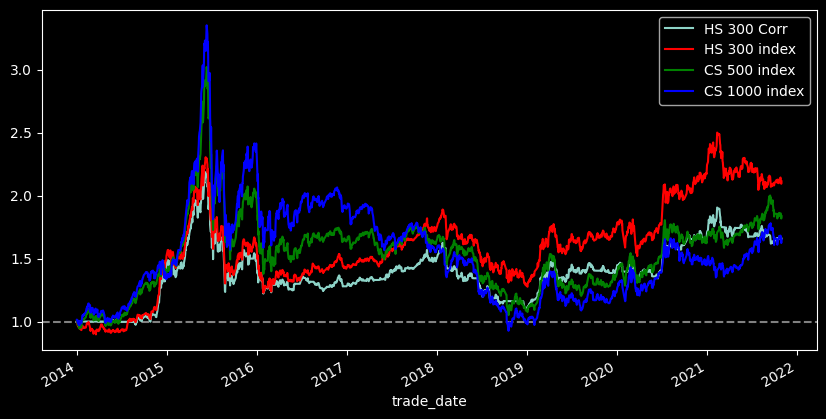

In [47]:
def Backtest(Asset_Equity, Label, Begin_date, End_date, Range_Bool=True):
    """
    Range_Bool=True: Use range dates
    Range_Bool=False: Use all dates
    """
    plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
    plt.figure(figsize=(10, 5))
    plt.axhline(y=1, color="grey", linestyle="--")

    def Date_Range(Series, Begin_date, End_date):
        return Series[(Series.index >= Begin_date) & (Series.index <= End_date)]
    
    profit_HS300 = HS_300_Return.apply(lambda x: x + 1)
    HS300_Equity = profit_HS300.cumprod()
    HS300_Equity = Date_Range(HS300_Equity, Begin_date, End_date) if Range_Bool else HS300_Equity
    HS300_Equity = HS300_Equity / HS300_Equity[0]
    
    profit_ZZ500 = ZZ_500_Return.apply(lambda x: x + 1)
    ZZ500_Equity = profit_ZZ500.cumprod()
    ZZ500_Equity = Date_Range(ZZ500_Equity, Begin_date, End_date) if Range_Bool else ZZ500_Equity
    ZZ500_Equity = ZZ500_Equity / ZZ500_Equity[0]
    
    profit_ZZ1000 = ZZ_1000_Return.apply(lambda x: x + 1)
    ZZ1000_Equity = profit_ZZ1000.cumprod()
    ZZ1000_Equity = Date_Range(ZZ1000_Equity, Begin_date, End_date) if Range_Bool else ZZ1000_Equity
    ZZ1000_Equity = ZZ1000_Equity / ZZ1000_Equity[0]

    EQUITY = Date_Range(Asset_Equity, Begin_date, End_date) if Range_Bool else Asset_Equity
    EQUITY = EQUITY / EQUITY[0]
    EQUITY.plot(label=Label, legend=True)
    HS300_Equity.plot(label="HS 300 index", legend=True, color="r")
    ZZ500_Equity.plot(label="CS 500 index", legend=True, color="g")
    ZZ1000_Equity.plot(label="CS 1000 index", legend=True, color="b")
    plt.show()
    return HS300_Equity
# HS300_Equity = Backtest(Equity, "HS 300 Corr", "20230101", "20240801", Range_Bool=False)

# def Backtest(Asset_Equity, Label):
#     plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
#     plt.figure(figsize=(10, 5))
#     plt.axhline(y=1, color="grey", linestyle="--")

#     profit_HS300 = HS_300_Return.apply(lambda x: x + 1)
#     HS300_Equity = profit_HS300.cumprod()
#     profit_ZZ500 = ZZ_500_Return.apply(lambda x: x + 1)
#     ZZ500_Equity = profit_ZZ500.cumprod()
#     profit_ZZ1000 = ZZ_1000_Return.apply(lambda x: x + 1)
#     ZZ1000_Equity = profit_ZZ1000.cumprod()

#     Asset_Equity.plot(label=Label, legend=True)
#     HS300_Equity.plot(label="HS 300 index", legend=True, color="r")
#     ZZ500_Equity.plot(label="CS 500 index", legend=True, color="g")
#     ZZ1000_Equity.plot(label="CS 1000 index", legend=True, color="b")
#     plt.show()
#     return HS300_Equity
# HS300_Equity = Backtest(Equity, "HS 300 Corr")

In [48]:
def Backtest_Indexes(Asset_Equity, Asset_Return, Benchmark_Equity, Benchmark_Return, Quote):
    """
    Asset_Equity: Asset equity list for every trading day
    Asset_Profit: 
    """
    print(Quote)
    # ROI
    Day_Len = len(Asset_Equity)
    ALL_Asset_ROI = (Asset_Equity[-1] - Asset_Equity[0]) / Asset_Equity[0]
    Yield_Asset_ROI = (1 + Asset_Equity[-1] - Asset_Equity[0]) ** (252 / Day_Len) - 1
    print(f"All Asset ROI: {ALL_Asset_ROI * 100: .2f}%")
    print(f"Yeild Asset ROI: {Yield_Asset_ROI * 100: .2f}%")
    print("*" * 40)

    ALL_Benchmark_ROI = (Benchmark_Equity[-1] - Benchmark_Equity[0]) / Benchmark_Equity[0]
    Yield_Benchmark_ROI = (1 + Benchmark_Equity[-1] - Benchmark_Equity[0]) ** (252 / Day_Len) -1
    print(f"All Benchmark ROI: {ALL_Benchmark_ROI * 100: .2f}%")
    print(f"Yeild Benchmark ROI: {Yield_Benchmark_ROI * 100: .2f}%")
    print("*" * 40)

    # Max Drawdown
    # Calculate the previous peaks
    previous_peaks = Asset_Equity.cummax()
    # Calculate the drawdowns
    drawdowns = (Asset_Equity - previous_peaks) / previous_peaks

    # Find the maximum drawdown and the dates associated with it
    # Convert the index labels to a numeric format
    drawdowns.index = pd.to_numeric(drawdowns.index)
    max_drawdown = drawdowns.min()
    print(f"Max drawdown: {max_drawdown}")
    max_drawdown_start = drawdowns.idxmin()

    # Convert the start and end dates back to the original format if needed
    max_drawdown_start = pd.to_datetime(max_drawdown_start).date()
    print(f"Max drawdown begin date: {max_drawdown_start}")
    print("*" * 40)

    # Beta = cov(Asset Equity, Benchmark Equity) / Var(Benchmark Equity)
    # Alpha = Yield Asset ROI - (Riskless ROI + β * (Yield Benchmark ROI - Riskless ROI))
    """
    α > 0 strategy has achieved excess returns relative to the market
    α = 0 strategy achieved an appropriate return relative to the market
    α < 0 strategy has achieved relatively low returns relative to the market

    β < 0 portfolios and benchmarks usually move in the opposite direction, such as short positions
    β = 0 There is no correlation between the direction of the portfolio and the benchmark, such as fixed income
    0 < β < 1 The portfolio and benchmark move in the same direction, but by a smaller margin than the benchmark
    β = 1 Portfolio and benchmark move in the same direction and close to the benchmark
    β > 1 portfolios and benchmarks move in the same direction, but more dramatically than benchmarks
    """
    Beta = Asset_Equity.cov(Benchmark_Equity) / Benchmark_Equity.var()
    Alpha = Yield_Asset_ROI - (0.03 + Beta * (Yield_Benchmark_ROI - 0.03))
    print(f"β: {Beta: .2f}")
    print(f"α: {Alpha: .2f}")
    print("*" * 40)

    # Daily Volatility = sqrt(sum((Equity - mean(Equity)) ** 2))
    # Annual Volatility = sqrt(252) * Daily Volatility
    # Sharpe ratio
    Asset_Annual_Volatility = np.sqrt(252 * np.sum((Asset_Return - np.mean(Asset_Return)) ** 2) / Day_Len)
    Benchmark_Annual_Volatility = np.sqrt(252 * np.sum((Benchmark_Return - np.mean(Benchmark_Return)) ** 2) / Day_Len)
    Asset_Sharpe_Ratio = (Yield_Asset_ROI - 0.03) / Asset_Annual_Volatility
    Benchmark_Sharpe_Ratio = (Yield_Benchmark_ROI - 0.03) / Benchmark_Annual_Volatility
    print(f"Asset Annual Volatility: {Asset_Annual_Volatility: .2f}")
    print(f"Benchmark Annual Volatility: {Benchmark_Annual_Volatility: .2f}")
    print(f"Asset Sharpe Ratio: {Asset_Sharpe_Ratio: .2f}")
    print(f"Benchmark Sharpe Ratio: {Benchmark_Sharpe_Ratio: .2f}")
    print("*" * 40)

    # Winning rate
    # Profit Loss ratio
    # Profit_Posstive = Asset_Profit[Asset_Profit > 0]
    # Profit_Negative = Asset_Profit[Asset_Profit < 0]
    # Winning_Rate = len(Profit_Posstive) / Day_Len
    # Profit_Loss_Ratio = np.sum(Profit_Posstive) / abs(np.sum(Profit_Negative))
    # print(f"Winning rate: {Winning_Rate * 100: .2f}%")
    # print(f"Profit Loss rate: {Profit_Loss_Ratio: .2f}")
    # print("*" * 40)

# Backtest_Indexes(Equity, Profit, HS300_Equity, HS_300_Return, "(HS300 Corr VS. HS300 Benchmark)")

(HS300 Corr VS. HS300 Benchmark)
All Asset ROI:  65.83%
Yeild Asset ROI:  6.92%
****************************************
All Benchmark ROI:  111.40%
Yeild Benchmark ROI:  10.40%
****************************************
Max drawdown: -0.49974722836758295
Max drawdown begin date: 2019-01-03
****************************************
β:  0.61
α: -0.01
****************************************
Asset Annual Volatility:  0.21
Benchmark Annual Volatility:  0.23
Asset Sharpe Ratio:  0.19
Benchmark Sharpe Ratio:  0.32
****************************************
